---
title: "Analysis of Time-series Data"
format:
    html:
        toc: true
        highlight-style: ayu
---

On this project, we'll analyze two datasets: the annual average temperature from [Peru](https://climateknowledgeportal.worldbank.org/country/peru/climate-data-historical) and a stocks market dataset.



In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [2]:
temp_df = pd.read_csv("observed-annual-average-mean-surface-air-temperature-of-junín,-peru-for-1901-2022.csv", sep=",")
temp_df = temp_df.rename(columns={"Category":"Year", "Annual Mean":"Temp_annual_mean"}).drop(columns=["5-yr smooth"])


prec_df = pd.read_csv("observed-annual-precipitation-of-junín,-peru-for-1901-2022.csv", sep=",")
prec_df = prec_df.rename(columns={"Category":"Year", "Annual Mean":"Prec_annual_mean"}).drop(columns=["5-yr smooth"])

climate_df = pd.merge(temp_df, prec_df, on="Year", how="left")
climate_df

,Year,Temp_annual_mean,Prec_annual_mean
0,1901,14.17,1273.85
1,1902,14.16,1273.85
2,1903,13.85,1273.85
3,1904,13.70,1273.85
4,1905,14.07,1273.85
...,...,...,...
117,2018,14.65,1273.85
118,2019,14.84,1262.93
119,2020,15.00,1273.85
120,2021,14.97,1046.47


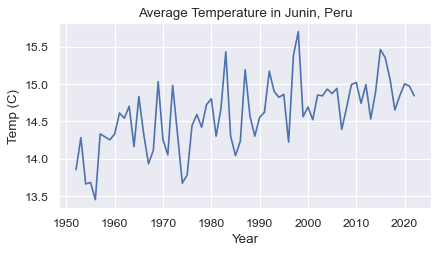

,Year,Temp_annual_mean,Prec_annual_mean
51,1952,13.85,1287.30
52,1953,14.28,1345.91
53,1954,13.66,1328.92
54,1955,13.68,1008.42
55,1956,13.45,1080.09


In [8]:
plt.figure(figsize=(6, 3), dpi=80)
subset_df = climate_df[climate_df.Year > 1951] 

sns.lineplot(data=subset_df, x="Year", y="Temp_annual_mean")
plt.title("Average Temperature in Junin, Peru")
plt.ylabel('Temp (C)')
plt.show()
subset_df.head()

## Linear Regression

In [15]:
x = subset_df["Year"].values
y = subset_df["Temp_annual_mean"].values

train_test_split = int(len(x) * 0.8)

train_temp, test_temp = y[:train_test_split], y[train_test_split:]
train_date, test_date = x[:train_test_split], x[train_test_split:]
assert(len(train_date) + len(test_date) == len(x))

temp_test = subset_df.iloc[train_test_split:,:].copy()
temp_train = subset_df.iloc[0:train_test_split,:].copy()


### Training

In [24]:
linear_trend = LinearRegression()

linear_trend.fit(train_date.reshape(-1,1), train_temp.reshape(-1,1))

coefficients = [linear_trend.coef_[0],linear_trend.intercept_]
print("The linear model is F(t) = " +str(coefficients[0])+"*t + (" +str(coefficients[1])+")")

linear_prediction = linear_trend.predict(train_date.reshape(-1,1))

The linear model is F(t) = [0.01585954]*t + ([-16.88984279])


<Axes: >

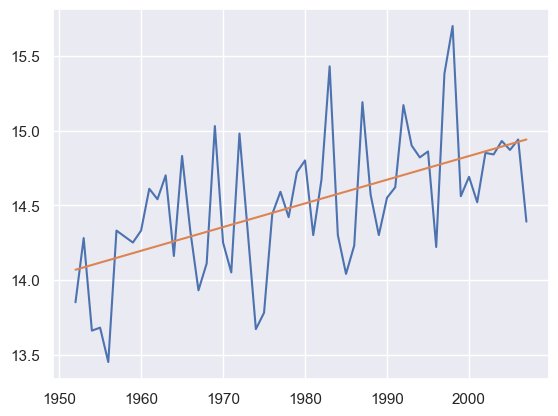

In [57]:
sns.lineplot(x=train_date, y=train_temp)
sns.lineplot(x=train_date, y=linear_prediction.flatten())

<Axes: >

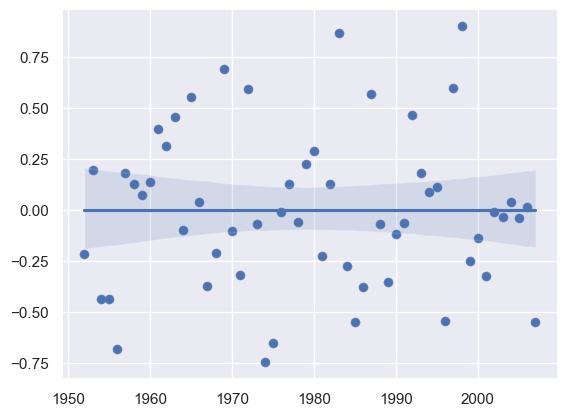

In [50]:
linear_residuals = train_temp.reshape(-1,1) - linear_prediction

sns.scatterplot(x=train_date.flatten(), y=linear_residuals.flatten())
sns.regplot(x=train_date.flatten(), y=linear_residuals.flatten())

### Testing

<Axes: >

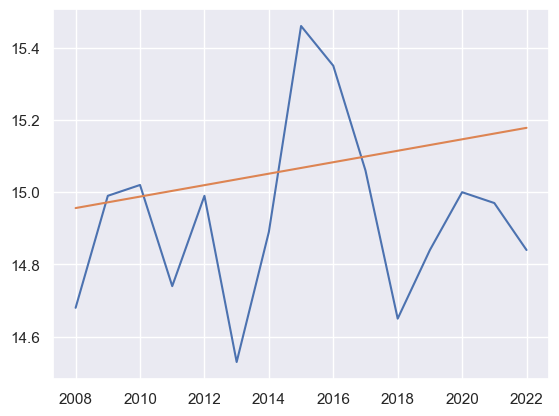

In [60]:
linear_test = linear_trend.predict(np.array(test_date).reshape(-1, 1))

sns.lineplot(x=test_date, y=test_temp)
sns.lineplot(x=test_date, y=linear_test.flatten())

In [61]:
rmse_linear = (mean_squared_error(test_temp, linear_test,squared=False))
print("RMSE on test data: " + str(rmse_linear))
mape_linear = mean_absolute_percentage_error(test_temp, linear_test)
print("MAPE on test data: " + str(mape_linear))

RMSE on test data: 0.27443386758161786
MAPE on test data: 0.015313627115465862


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Quadratic Regression

### Training

In [65]:
degree=2
model_2=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_2.fit(train_date.reshape(-1,1), train_temp.reshape(-1,1))
quadratic = model_2.predict(train_date.reshape(-1,1))

<Axes: >

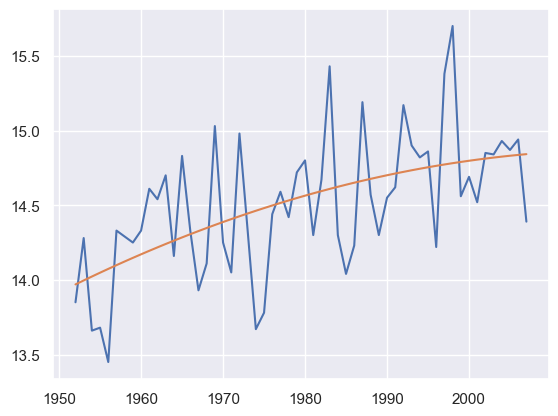

In [73]:
sns.lineplot(x=train_date.flatten(), y=train_temp.flatten())
sns.lineplot(x=train_date.flatten(), y=quadratic.flatten())

<Axes: >

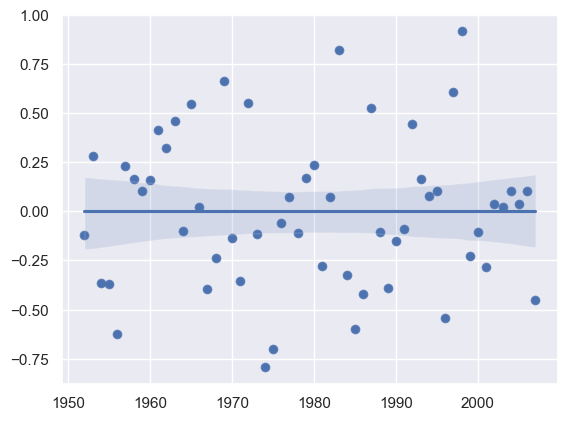

In [74]:
quadratic_residuals = train_temp.reshape(-1,1) - quadratic

sns.scatterplot(x=train_date.flatten(), y=quadratic_residuals.flatten())
sns.regplot(x=train_date.flatten(), y=quadratic_residuals.flatten())

### Testing

<Axes: >

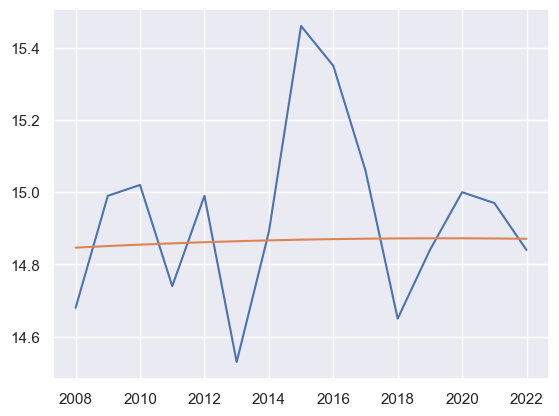

In [75]:
quadratic_test = model_2.predict(np.array(test_date).reshape(-1, 1))

sns.lineplot(x=test_date, y=test_temp)
sns.lineplot(x=test_date, y=quadratic_test.flatten())

In [76]:
rmse_linear = (mean_squared_error(test_temp, quadratic_test,squared=False))
print("RMSE on test data: " + str(rmse_linear))
mape_linear = mean_absolute_percentage_error(test_temp, quadratic_test)
print("MAPE on test data: " + str(mape_linear))

RMSE on test data: 0.24631133459504706
MAPE on test data: 0.012622590435811109


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
temp_train["quadratic_residuals"] = quadratic_residuals

temp_train.head(n=10)

,Year,Temp_annual_mean,Prec_annual_mean,quadratic_residuals
51,1952,13.85,1287.30,-0.119602
52,1953,14.28,1345.91,0.283808
53,1954,13.66,1328.92,-0.362385
54,1955,13.68,1008.42,-0.368181
55,1956,13.45,1080.09,-0.623579
56,1957,14.33,1257.51,0.231420
57,1958,14.29,1308.24,0.166816
58,1959,14.25,1577.45,0.102610
59,1960,14.33,1109.59,0.158802
60,1961,14.61,1512.86,0.415391


## Autoregressive Plots on Quadratic Trend

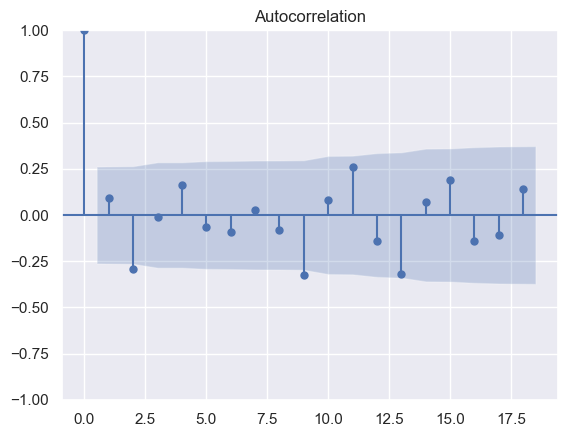

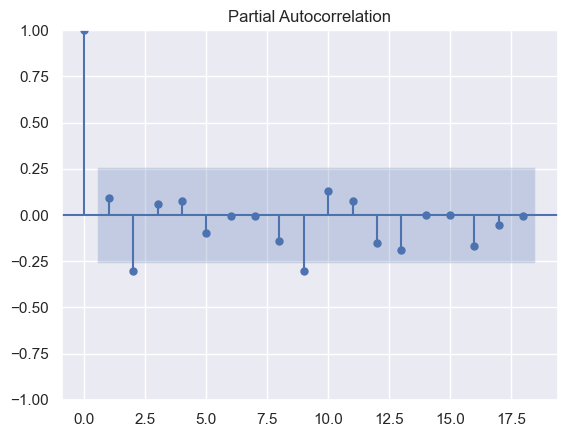

In [78]:
sm.graphics.tsa.plot_acf(quadratic_residuals)
plt.show()
sm.graphics.tsa.plot_pacf(quadratic_residuals)
plt.show()

## Fitting ARMA Model

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Params:
 [-0.00294043 -0.46959189 -0.32489186 -0.21875888  0.50882518  0.54577816
  0.12670074  0.15061197 -0.13207879 -0.66759902  0.56727919  0.22288114
  0.06103443 -0.77899895 -0.9240922  -0.24495664 -0.33395425 -0.0595508
  0.50660003  0.0767308 ]


c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


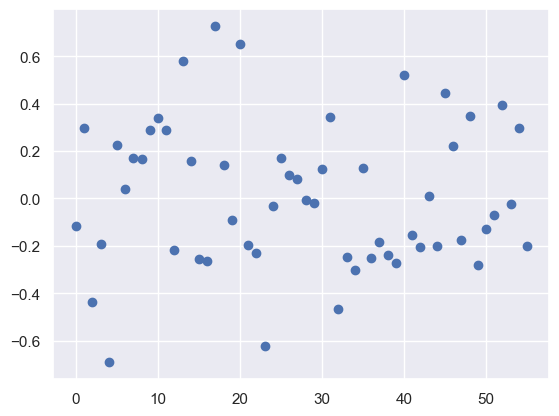

In [141]:
from statsmodels.tsa.arima.model import ARIMA

AR_order = 9
ar_higher = ARIMA(quadratic_residuals, order=(AR_order, 0, 9)).fit()

# print(ar_higher.summary())
print(f"Params:\n {ar_higher.params}")
ar_higher_predictions = ar_higher.predict()

ar_higher_residuals = quadratic_residuals.reshape(-1,1) - ar_higher_predictions.reshape(-1,1)

plt.plot(ar_higher_residuals, 'o')
plt.show()

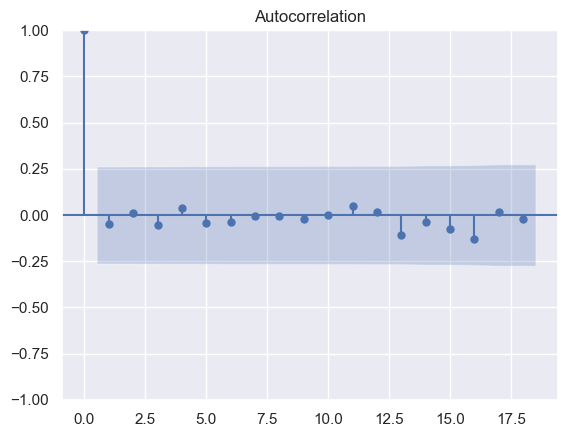

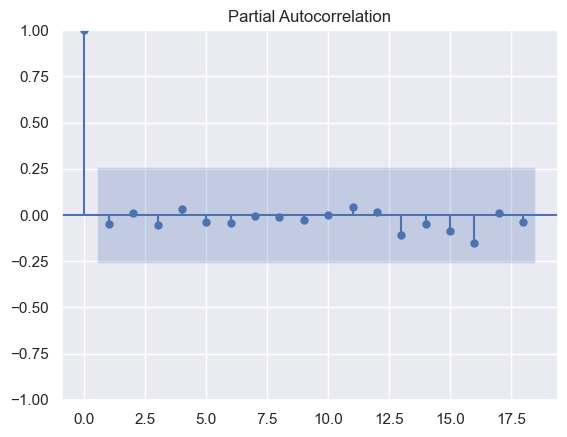

In [142]:
sm.graphics.tsa.plot_acf(ar_higher_residuals)
plt.show()
sm.graphics.tsa.plot_pacf(ar_higher_residuals)
plt.show()

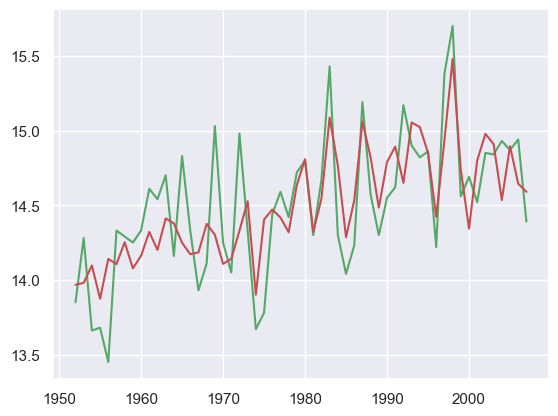

In [143]:
model_train = quadratic + ar_higher_predictions.reshape(-1,1)

plt.plot(train_date.flatten(), train_temp.flatten(),c="g")
plt.plot(train_date.flatten(), model_train.flatten(), c="r")

# p = figure(title = "CO2 Variation with time")
# p.scatter(train_date.flatten(),train_co2.flatten(),size=3, line_color="black", fill_color="green", fill_alpha=0.5, legend_label ="Training Data")
# p.line(train_date.flatten(), model_train.flatten(),line_color="red",line_width=2.5,legend_label ="Final Model (Training Data Fit)")
# p.scatter(test_date.flatten(),test_co2.flatten(),size=2, line_color="olive", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
# p.line(test_date.flatten(),model_test.flatten(),line_color="orange",line_width=2.5,legend_label ="Final Model Predictions")
# p.legend.location = "top_left"
# show(p)